# Imports

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten,Dense, Dropout
from keras.models import Model
from keras import Input
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from keras.applications import DenseNet201
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

# Data

In [ ]:
# load the Cifar10 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33)

In [ ]:
#creat one_hot output
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_val = keras.utils.to_categorical(y_val)

In [ ]:
#preprocessing data for densenet
x_train = keras.applications.densenet.preprocess_input(x_train)
x_test = keras.applications.densenet.preprocess_input(x_test)
x_val = keras.applications.densenet.preprocess_input(x_val)

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
train_generator = datagen.flow(x_train,y_train,batch_size=512)
test_generator = datagen.flow(x_test,y_test,batch_size=512)
val_generator = datagen.flow(x_val,y_val,batch_size=512)

# model

## Creat model

In [ ]:
inputs = Input(shape=(32, 32, 3))
# Resizing images
resized_images = Resizing(height=224, width=224)(inputs)

In [ ]:
#pretrained model
model = DenseNet201(include_top=False,weights='imagenet',input_tensor=resized_images,input_shape=(224, 224, 3))

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
# Freeze all layers except those from conv5_block1_0_bn onwards
for layer in model.layers:
  if layer.name == 'conv5_block1_0_bn':
    break
  layer.trainable = False

In [ ]:
x = model.layers[-1].x
x = Flatten()(x)
x = Dense(units=256,activation='elu')(x)
x = Dropout(0.5)(x)
x = Dense(units=10,activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['resizing[0][0]']               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                             

## Train model

In [ ]:
optimizer=keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
lr_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',factor=0.6,min_lr=0.0000001)

In [ ]:
history = model.fit(train_generator,epochs=10,batch_size=512,validation_data=val_generator,callbacks=lr_reduce,shuffle=True)

Epoch 1/10
66/66 [==============================] - 382s 4s/step - loss: 2.0904 - accuracy: 0.7776 - val_loss: 1.3506 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 2/10
66/66 [==============================] - 243s 4s/step - loss: 0.3414 - accuracy: 0.8998 - val_loss: 0.3506 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 3/10
66/66 [==============================] - 242s 4s/step - loss: 0.2277 - accuracy: 0.9290 - val_loss: 0.3695 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 4/10
66/66 [==============================] - 243s 4s/step - loss: 0.1818 - accuracy: 0.9448 - val_loss: 0.2592 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 5/10
66/66 [==============================] - 243s 4s/step - loss: 0.1333 - accuracy: 0.9582 - val_loss: 0.3238 - val_accuracy: 0.9322 - lr: 0.0010
Epoch 6/10
66/66 [==============================] - 242s 4s/step - loss: 0.1083 - accuracy: 0.9663 - val_loss: 0.3494 - val_accuracy: 0.9302 - lr: 0.0010
Epoch 7/10
66/66 [==============================] - 243s 4s/step - loss: 0.0

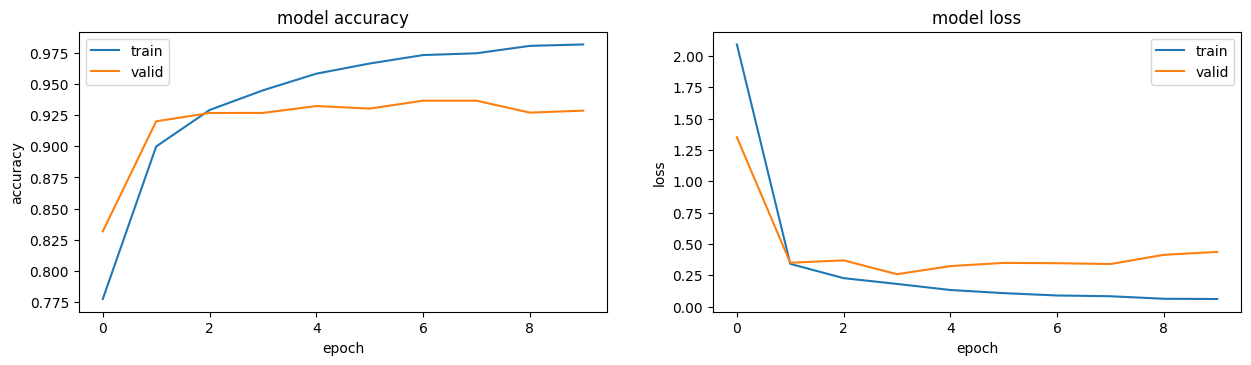

In [ ]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()